In [56]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit

In [57]:
# define functions
def LinearFunc(t, a, b):
    return a * t + b

def AiryFunc(t, B, A, F, T, t0):
    return B + A / ( 1 + F * (np.sin( (np.pi/T)*(t-t0) ))**2 )

def ChiSqrd(Data, Fit, Error):
    return sum( (Data - Fit)**2 ) / (Error**2)

def RdChiSqrd(Data, Fit, Error, NumPrams):
    return sum( (Data - Fit)**2 ) / (Error**2 * (np.size(Data) - NumPrams - 2))

def Cali(t, t0, DriveSlope, FPDriveSlope, FP_Period):
    return ((DriveSlope * 10)/(FPDriveSlope*FP_Period))*(t - t0)

def func(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
    return y

## Calibration with the Fabry-Perot

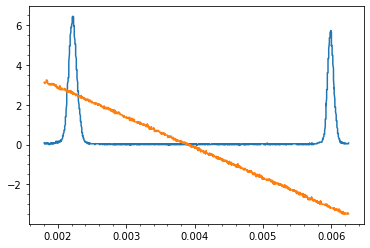

In [58]:
# Importing and formatting data

# Reading Files
ramp0 = pd.read_csv("New Data/Calibration (Widest)/A0032CH1.CSV")
FP0 = pd.read_csv("New Data/Calibration (Widest)/A0032CH2.CSV")

#Seperating Data
RawRampTime = pd.DataFrame(ramp0, columns= ['col 1'])
RawRamp = pd.DataFrame(ramp0, columns= ['col 2'])
RawFPTime = pd.DataFrame(FP0, columns= ['col 1'])
RawFP = pd.DataFrame(FP0, columns= ['col 2'])

#Formatting Data
RampTime = np.resize(RawRampTime,(4000,1))
Ramp = np.resize(RawRamp,(4000,1))
FabryTime = np.resize(RawFPTime,(4000,1))
Fabry = np.resize(RawFP,(4000,1))

t_start = 0.0018
t_end = 0.00625

#pulling out important indices
j = 0
for i in FabryTime: 
    if i == t_start:
        t1 = j
    if i == t_end:
        t2 = j
    if i == 0.0027:
        tf1 = j
    if i == 0.0055:
        tf2 = j
    j += 1

#Resizing and cutting
BackgroundT_pts = FabryTime[tf1:tf2,0]
BackgroundFabry = Fabry[tf1:tf2,0]

RampTime = RampTime[t1:t2,0]
Ramp = Ramp[t1:t2,0]
FabryTime = FabryTime[t1:t2,0]
Fabry = Fabry[t1:t2,0]

#DoubleChecking Times
TimeDiff = RampTime - FabryTime

for i in TimeDiff:
    if i != 0:
        print("ERROR")
        
t_pts = FabryTime

plt.plot(t_pts, Fabry)
plt.plot(t_pts, Ramp*(30))
#plt.plot(BackgroundT_pts, BackgroundFabry)
plt.minorticks_on()

In [59]:
# Finding the error for our fit
BackgroundGuess = [0, 0.02]

BackParam, BackParam_cov = curve_fit(LinearFunc, BackgroundT_pts, BackgroundFabry, BackgroundGuess, maxfev=150000)

FPV_error = np.sqrt( sum( (BackgroundFabry - LinearFunc(BackgroundT_pts, *BackParam))**2 ) / (np.size(BackgroundT_pts) - 2) )
FPV_errorArray = FPV_error * np.linspace(1,1,np.size(t_pts))
print("")
print("Error in the voltage for the Fabry-Perot = (+/-) " + str(FPV_error) + " V")


Error in the voltage for the Fabry-Perot = (+/-) 0.020478307755054048 V



index 0 = -0.057733425024948964 +/- 0.006112601857593265
index 1 = 6.397591186499927 +/- 0.039800003795294255
index 2 = 550.9051571754346 +/- 10.35723055993203
index 3 = 0.0037712480828737092 +/- 6.360550554642151e-07
index 4 = 0.0022162486963091224 +/- 4.497310172885512e-07

Chi Squared = 336189.1609859879
Reduced Chi Squared = 151.5731113552696


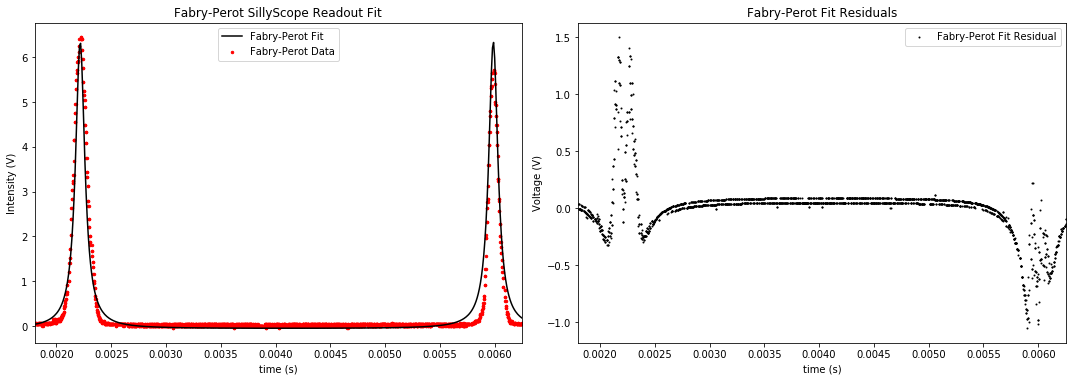

In [60]:
# Fitting and plotting the Fabry-Perot

FPGuess = [0, 6, 550, .00377, .0022]
FPParam, FPParam_cov = curve_fit(AiryFunc, t_pts, Fabry, FPGuess, sigma= FPV_errorArray, maxfev=150000)

#print("0: Background") print("1: Amplitude") print("2: Finness") print("3: Period") print("4: t0")
print("")

i = 0
while i < 5:
    print("index " + str(i) + " = " + str(FPParam[i]) + " +/- " + str(np.sqrt(FPParam_cov[i,i])) )
    i += 1
    
FP_Period = FPParam[3]
FP_Period_Err = np.sqrt(FPParam_cov[3,3])

print("")
FP_RCS = RdChiSqrd(Fabry, AiryFunc(t_pts, *FPParam), FPV_error, 5)
FP_CS = ChiSqrd(Fabry, AiryFunc(t_pts, *FPParam), FPV_error)

print("Chi Squared = " + str(FP_CS))
print("Reduced Chi Squared = " + str(FP_RCS))

fig = plt.figure(figsize=(15,10))
FPplt = fig.add_subplot(2,2,1)
#FPplt.scatter(RelativeFreq, Fabry, label='Fabry-Perot Data', color='red', s=6)
FPplt.scatter(t_pts, Fabry, label='Fabry-Perot Data', color='red', s=6)
FPplt.plot(t_pts, AiryFunc(t_pts, *FPParam), label='Fabry-Perot Fit', color='black')
#FPplt.errorbar(t_pts, Fabry, color='red', yerr= FPV_error, capsize= 3)
FPplt.set_xlim(t_start,t_end)
#FPplt.set_xlim(-2,12)
FPplt.set_xlabel("time (s)")
FPplt.set_ylabel('Intensity (V)')
FPplt.set_title('Fabry-Perot SillyScope Readout Fit')
FPplt.legend();

FPResidplt = fig.add_subplot(2,2,2)
FPResidplt.scatter(t_pts, (Fabry - AiryFunc(t_pts, *FPParam)), label='Fabry-Perot Fit Residual', color='black', s=1)
FPResidplt.set_xlim(t_start,t_end)
FPResidplt.set_xlabel("time (s)")
FPResidplt.set_ylabel('Voltage (V)')
FPResidplt.set_title('Fabry-Perot Fit Residuals')
FPResidplt.legend();

fig.tight_layout()


index 0 = -0.057733425024948964 +/- 0.006112601857593265
index 1 = 6.397591186499927 +/- 0.039800003795294255



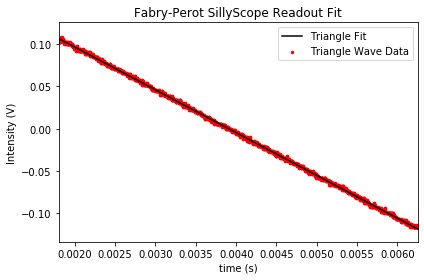

In [61]:
# Fitting and plotting the Triangle Wave

TriGuess = [-0.06, 6.4]
TriParam, TriParam_cov = curve_fit(LinearFunc, t_pts, Ramp, TriGuess, maxfev=150000)

#print("0: Background") print("1: Amplitude") print("2: Finness") print("3: Period") print("4: t0")
print("")

i = 0
while i < 2:
    print("index " + str(i) + " = " + str(FPParam[i]) + " +/- " + str(np.sqrt(FPParam_cov[i,i])) )
    i += 1
    
FPTriSlope = TriGuess[0]

print("")
#Tri_RCS = RdChiSqrd(Fabry, AiryFunc(t_pts, *FPParam), FPV_error, 5)
#Tri_CS = ChiSqrd(Fabry, AiryFunc(t_pts, *FPParam), FPV_error)

#print("Chi Squared = " + str(FP_CS))
#print("Reduced Chi Squared = " + str(FP_RCS))

fig = plt.figure()
FPplt = fig.add_subplot(1,1,1)
FPplt.scatter(t_pts, Ramp, label='Triangle Wave Data', color='red', s=6)
FPplt.plot(t_pts, LinearFunc(t_pts, *TriParam), label='Triangle Fit', color='black')
#FPplt.errorbar(t_pts, Fabry, color='red', yerr= FPV_error, capsize= 3)
FPplt.set_xlim(t_start,t_end)
#FPplt.set_xlim(-2,12)
FPplt.set_xlabel("time (s)")
FPplt.set_ylabel('Intensity (V)')
FPplt.set_title('Fabry-Perot SillyScope Readout Fit')
FPplt.legend();

fig.tight_layout()

## Full Spectrum Plot

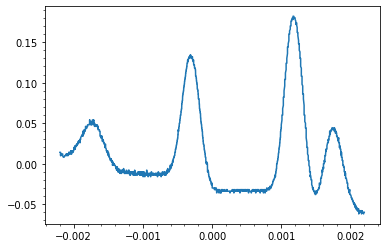

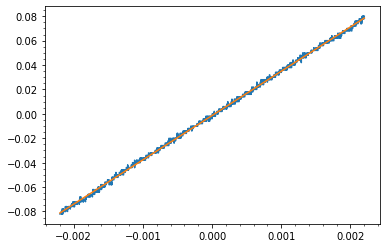

In [62]:
data =  pd.read_csv("New Data\Spectrum blocked (widest)/A0036CH1.CSV")
x = pd.DataFrame(data, columns= ['col 1'])
y = pd.DataFrame(data, columns= ['col 2'])
x = np.resize(x,(4000,1))
y = np.resize(y,(4000,1))

rampdata =  pd.read_csv("New Data\Spectrum blocked (widest)/A0036CH2.CSV")
rampx = pd.DataFrame(rampdata, columns= ['col 1'])
rampy = pd.DataFrame(rampdata, columns= ['col 2'])
rampx = np.resize(rampx,(4000,1))
rampy = np.resize(rampy,(4000,1))

j = 0
for i in x:
    if i == -0.0022:
        t1 = j
    if i == 0.0022:
        t2 = j
    j += 1

x = x[t1:t2,0]
y = y[t1:t2,0]
rampx = rampx[t1:t2,0]
rampy = rampy[t1:t2,0]

#y = y + 0.333333333*rampy + 0.01

RampGuess = [5, -2]
RampParam, RampParam_cov = curve_fit(LinearFunc, rampx, rampy, RampGuess, maxfev=150000)

RampSlope = (-1)*RampParam[0]

plt.plot(x,y)
plt.minorticks_on()
plt.show()
plt.plot(rampx,rampy)
plt.plot(rampx,LinearFunc(rampx,*RampParam))
plt.minorticks_on()
plt.show()

Y-error = (+/-) 0.0011244932906846706


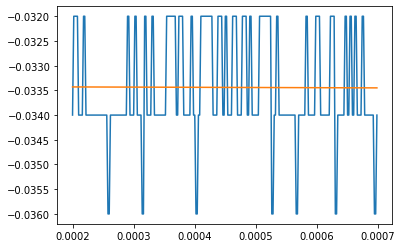

In [63]:
# Finds Error in the voltage

# Find flat '0' segments
# Here I'm taking from t=-0.0001 to t=0.0001
j = 0
for i in x: 
    if i == 0.0002:
        t1 = j
    if i == 0.0007:
        t2 = j
    j += 1
    
x_flat = x[t1:t2]
y_flat = y[t1:t2]

Back_guess = [0,-.034]

def linfunc(x_pts, a, b):
    return a * x_pts + b

Back_popt, Back_pcov = optimize.curve_fit(linfunc, x_flat, y_flat, Back_guess, maxfev=150000)

V_error = np.sqrt( sum( (y_flat - linfunc(x_flat, *Back_popt))**2 ) / (np.size(x_flat) - 2) )

print("Y-error = (+/-) " + str(V_error))


plt.plot(x_flat,y_flat)
plt.plot(x_flat, linfunc(x_flat, *Back_popt))
plt.show()

V_errorA = V_error * np.linspace(1,1,np.size(x))
    

Reduced Chi Squared = 368.77284865529424


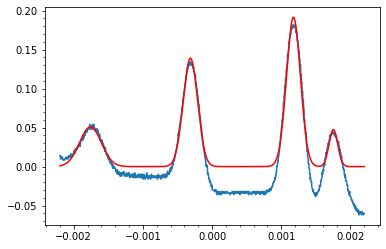

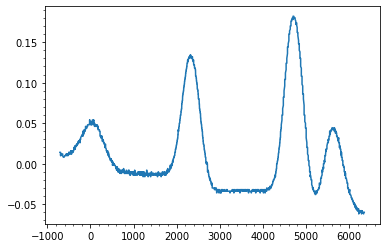

In [65]:
# Fit curve, apply Calibration, fit again

guess = [-0.0018, 0.05000, 0.00020, -0.00030, 0.15000, 0.00020, 0.00120, 0.21000, 0.00020, 0.0018, 0.05000, 0.00020]
# position, amplitude, width

popt, pcov = optimize.curve_fit(func, x, y, p0=guess, sigma= V_errorA, maxfev=150000)
fit = func(x, *popt)
RCS = RdChiSqrd(y, func(x, *popt), V_error, 12)
print("Reduced Chi Squared = " + str(RCS))

plt.plot(x, y)
plt.plot(x, fit , 'r-')
plt.minorticks_on()
plt.show()


# Calibration
Calx = Cali(x, popt[0], RampSlope, FPTriSlope, FP_Period)

#guess = [-0.0018, 0.05000, 0.00020, -0.00030, 0.15000, 0.00020, 0.00120, 0.21000, 0.00020, 0.0018, 0.05000, 0.00020]
# position, amplitude, width

#popt, pcov = optimize.curve_fit(func, x, y, p0=guess, sigma= V_errorA, maxfev=150000)
#fit = func(x, *popt)
#RCS = RdChiSqrd(y, func(x, *popt), V_error, 12)
#print("Reduced Chi Squared = " + str(RCS))

plt.plot(Calx, y)
#plt.plot(x, fit , 'r-')
plt.minorticks_on()
plt.show()


#i = 0
#while i < 12:
#    print("Pram(" + str(i) + "): " + str(popt[i]) + " +/- " + str(np.sqrt(pcov[i,i])) )
#    i += 1

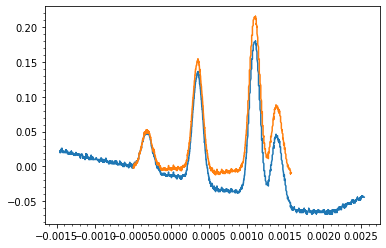

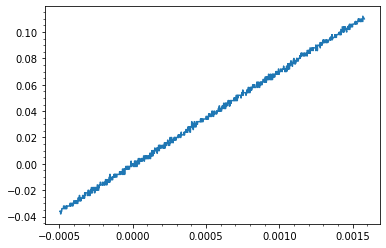

Y-error = (+/-) 0.0016216947220892288

Pram(0): -0.00031649965589272444 +/- 7.783410764536553e-07
Pram(1): 0.05204280110971164 +/- 0.000536939126215933
Pram(2): 9.243332924752745e-05 +/- 1.1038353248579268e-06
Pram(3): 0.00034992633568441367 +/- 2.5888731773699306e-07
Pram(4): 0.153191283010829 +/- 0.0005477301255471967
Pram(5): 8.867962128248772e-05 +/- 3.661219556767849e-07
Pram(6): 0.00109996665584301 +/- 1.8483801348797187e-07
Pram(7): 0.2189953469837204 +/- 0.0005419791785171465
Pram(8): 9.122115995672953e-05 +/- 2.650618044631444e-07
Pram(9): 0.001393092575255616 +/- 4.429096103492902e-07
Pram(10): 0.08874795820651075 +/- 0.0005575675493221338
Pram(11): 8.617383467799723e-05 +/- 6.351468715743078e-07

Reduced Chi Squared = 8.460756743326659


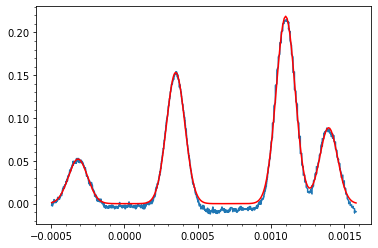

In [71]:
data =  pd.read_csv("A0005CH1.CSV")
data = np.array(data)
x,y = np.split(data, [-1], 1) # Divide into x and y for curve fitting
x.flatten() 
y.flatten()
x = np.hstack(x) # Fix stupid 2d array crap
y = np.hstack(y)

x = x[963:3036]
y = y[963:3036]
rampdata = pd.read_csv("A0005CH2.CSV")
rampdata = np.array(rampdata)
rampx, rampy = np.split(rampdata, [-1], 1)
rampx.flatten()
rampy.flatten()
rampx = np.hstack(rampx)
rampy = np.hstack(rampy)
rampx = rampx[963:3036]
rampy = rampy[963:3036]
y = y + 0.333333333*rampy + 0.01
plt.plot(x,y)
plt.minorticks_on()
plt.show()
plt.plot(rampx,rampy)
plt.minorticks_on()
plt.show()

def func(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
    return y

guess = [-0.00030, 0.05000, 0.00020, 0.00030, 0.15000, 0.00020, 0.00110, 0.21000, 0.00020, 0.00135, 0.08000, 0.00020]
# position, amplitude, width

################################################ Y Error Analisis
# Find flat '0' segments "manually"
# Automaticly cuts out the portion from t=-0.0001 to t=0.0001
j = 0
for i in x: 
    if i == -0.0001:
        t1 = j
    if i == 0.0001:
        t2 = j
    j += 1
    
x_flat = x[t1:t2]
y_flat = y[t1:t2]

Back_guess = [7,-.004]

def linfunc(x_pts, a, b):
    return a * x_pts + b

Back_popt, Back_pcov = optimize.curve_fit(linfunc, x_flat, y_flat, Back_guess, maxfev=150000)

V_error = np.sqrt( sum( (y_flat - linfunc(x_flat, *Back_guess))**2 ) / (np.size(x_flat) - 2) )

print("Y-error = (+/-) " + str(V_error))
print("")

V_errorA = V_error * np.linspace(1,1,np.size(x))

#plt.plot(x_flat,y_flat)
#plt.plot(x_flat, linfunc(x_flat, *Back_guess))
#plt.show()

################################################



popt, pcov = optimize.curve_fit(func, x, y, p0=guess, sigma= V_errorA, maxfev=10000)
#print(popt)
fit = func(x, *popt)
#chi2 = np.sum((y - fit)**2/y)
#print(chi2)

i = 0
while i < 12:
    print("Pram(" + str(i) + "): " + str(popt[i]) + " +/- " + str(np.sqrt(pcov[i,i])) )
    i += 1
    
print("")
RCS = RdChiSqrd(y, func(x, *popt), V_error, 12)
print("Reduced Chi Squared = " + str(RCS))

plt.plot(x, y)
plt.plot(x, fit , 'r-')
plt.minorticks_on()
plt.show()

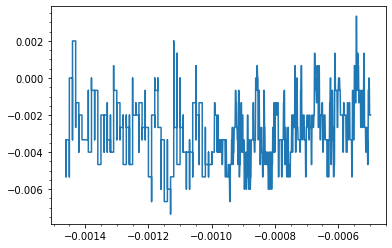

In [70]:
data =  pd.read_csv("A0005CH1.CSV")
data = np.array(data)
x,y = np.split(data, [-1], 1) # Divide into x and y for curve fitting
x.flatten() 
y.flatten()
x = np.hstack(x) # Fix stupid 2d array crap
y = np.hstack(y)
x = x[0:962]
y = y[0:962]
rampdata = pd.read_csv("A0005CH2.CSV")
rampdata = np.array(rampdata)
rampx, rampy = np.split(rampdata, [-1], 1)
rampx.flatten()
rampy.flatten()
rampx = np.hstack(rampx)
rampy = np.hstack(rampy)
rampx = rampx[0:962]
rampy = rampy[0:962]
y = y + 0.333333333*rampy + 0.01
plt.plot(x, y)
plt.minorticks_on()
plt.show()
